In [24]:
%matplotlib inline

import sys

sys.path.append("../../..")

import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
from time import time
import urllib

import navbench as nb
from navbench import imgproc as ip

# Set these properties for all figures
plt.rcParams["figure.figsize"] = [15, 8]
plt.rcParams["font.size"] = 20

DBROOT = "../../../datasets/rc_car/Stanmer_park_dataset"

# Boundaries for tests, e.g. a value of 50 means that 50 frames either side of the goal will be tested
FRAME_DIST = 50

# 1 == include every frame, 2 == every other frame etc.
FR_STEP = 1

# Rotational step for RIDF-type calculations
RIDF_STEP = 2

# Size of median filter to apply to values
MEDFILT_SIZE = 5

# Image preprocessing pipeline - if you provide a tuple of functions then each will be applied to the image in turn
RESIZE = ip.resize(55, 180)
PREPROC = (RESIZE, ip.remove_sky_and_histeq)

SNAP_STEP = 10

In [25]:
%%HTML
<div align="middle">
<h1>Data collection in Stanmer Park</h1>
<video width="80%" controls autoplay loop>
    <source src="../../../datasets/rc_car/drone_videos/2020-11-04/following robot 1.mp4" type="video/mp4">
</video></div>

In [26]:
%%HTML
<center>
<h2>Routes recorded on Day 1</h2>
<img src="routes.png" width="60%" /></center>

In [27]:
# Plot UTM coordinates
def plot_route(ax, db, *args, **kwargs):
    return ax.plot(db.x, db.y, *args, **kwargs)


def get_dataset_path(date, i):
    return "%s/dataset%d" % (date, i)


def get_dataset_paths(date):
    i = 1
    paths = []
    while True:
        path = get_dataset_path(date, i)
        if not os.path.exists(os.path.join(DBROOT, path)):
            break
        paths.append(path)
        i += 1
    return paths


def plot_routes(paths):
    _, ax = plt.subplots()

    for path in paths:
        plot_route(ax, nb.Database(os.path.join(DBROOT, path)), ":")

    ax.legend(paths)
    ax.axis("equal")
    ax.set_xlabel("x (m)")
    ax.set_ylabel("y (m)")

Loading database at ../../../datasets/rc_car/Stanmer_park_dataset/0411/unwrapped_dataset1...
Loading database at ../../../datasets/rc_car/Stanmer_park_dataset/0511/unwrapped_dataset1...


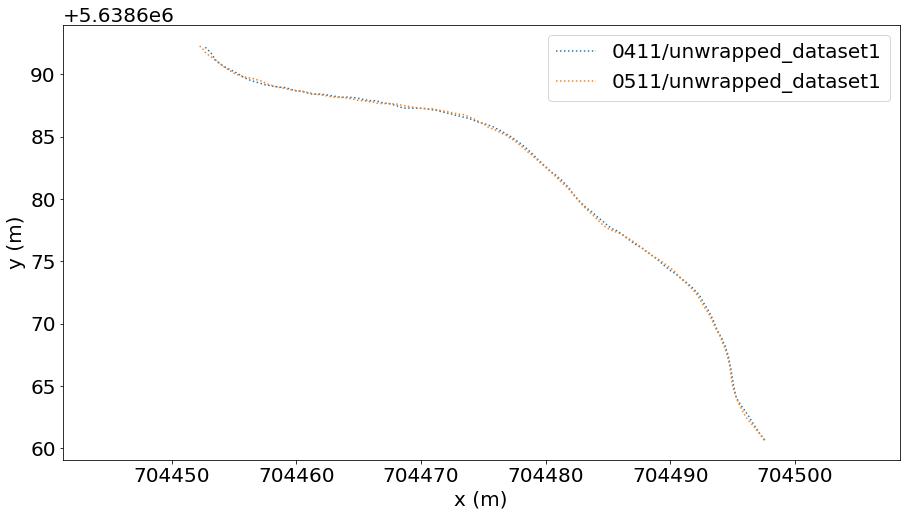

In [28]:
ax = plot_routes(["0411/unwrapped_dataset1", "0511/unwrapped_dataset1"])

In [29]:
%%HTML
<div align="middle">
<h2>Preprocessing: Sky removal and contrast normalisation</h2>
<video width="80%" playback_rate="4" controls loop>
    <source src="nosky.mp4">
</video></div>

In [30]:
GOAL = 400

db = nb.Database(os.path.join(DBROOT, "0411/unwrapped_dataset1"))
print("Database has %d images" % len(db))
print("Median filter size: %i" % MEDFILT_SIZE)


def plot_ca(ax, title, preprocess=None):
    preprocess = (RESIZE, preprocess)

    # Load images + snapshot + range of entry indices
    (images, snap, entries) = db.load_test_frames(GOAL, FRAME_DIST, preprocess, FR_STEP)

    # Get best-matching image across rotations for each point
    # (There is a route_idf function that doesn't use rotation)
    idf = nb.route_ridf(images, snap)

    # Calculate distance in m from snapshot location
    dists = db.calculate_distances(GOAL, entries)

    # Calculate catchment area
    ca = nb.calculate_ca(idf, medfilt_size=MEDFILT_SIZE)

    # Calculate CA size in m
    # (NB: value may be counterintuitive if robot is turning)
    ca_size = db.calculate_distance(*ca.bounds)

    ca.plot(dists, ax=ax, ymax=0.12)
    ax.set_xlabel("Distance (m) [CA size: %g m]" % ca_size)
    ax.set_ylabel("Image difference (px)")
    ax.set_title(title)

Loading database at ../../../datasets/rc_car/Stanmer_park_dataset/0411/unwrapped_dataset1...
Database has 480 images
Median filter size: 5


Testing frames 350 to 450 (n=101)
1 zero values are not being shown
Testing frames 350 to 450 (n=101)
1 zero values are not being shown


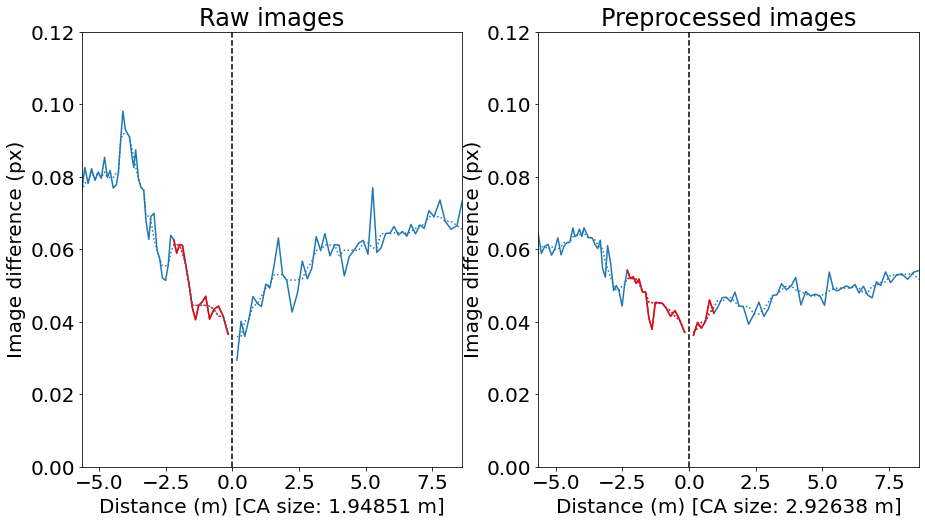

In [31]:
# Effect of preprocessing on navigation
_, ax = plt.subplots(1, 2)
plot_ca(ax[0], "Raw images")
plot_ca(ax[1], "Preprocessed images", ip.remove_sky_and_histeq)

In [33]:
def load_db(path):
    db = nb.Database(os.path.join(DBROOT, path))
    print("Database %s has %d images" % (path, len(db)))
    return db


def get_ca_sizes(db, images, snapshots):
    ca_sizes = []

    # Cache result because this step takes aaaaages
    pkl_path = "ca_sizes_%s.pkl" % urllib.parse.quote_plus(db.path)
    if os.path.exists(pkl_path):
        ca_sizes, num_inf = pickle.load(open(pkl_path, "rb"))
    else:
        num_inf = 0
        for goal_idx, snap in enumerate(snapshots):
            diffs = nb.route_ridf(images, snap, step=2)
            ca = nb.calculate_ca(diffs, goal_idx, MEDFILT_SIZE)
            size = db.calculate_distance(*ca.get_finite_bounds())
            num_inf += math.isinf(ca.size())
            ca_sizes.append(size)
        pickle.dump((ca_sizes, num_inf), open(pkl_path, "wb"))

    if num_inf:
        print("WARNING: %i/%i CAs extended beyond route end" % (num_inf, len(ca_sizes)))

    print("CA range: [%f, %f]" % (np.amin(ca_sizes), np.amax(ca_sizes)))
    return ca_sizes


names = ["0511/unwrapped_dataset%d" % num for num in range(1, 6)]
descriptions = [
    "0 m away",
    "0 m away (repeat)",
    "1 m away (left)",
    "1 m away (right)",
    "2 m away (right)",
]
dbs = []
images = []

for name in names:
    dbs.append(load_db(name))
    images.append(dbs[-1].read_images(preprocess=PREPROC))

print("Calculating CAs...")
t0 = time()
snapshots = images[0][0::SNAP_STEP]
ca_sizes = [get_ca_sizes(db, im, snapshots) for db, im in zip(dbs, images)]
print("Elapsed: %g s" % (time() - t0))

Loading database at ../../../datasets/rc_car/Stanmer_park_dataset/0511/unwrapped_dataset1...
Database 0511/unwrapped_dataset1 has 411 images
Loading database at ../../../datasets/rc_car/Stanmer_park_dataset/0511/unwrapped_dataset2...
Database 0511/unwrapped_dataset2 has 367 images
Loading database at ../../../datasets/rc_car/Stanmer_park_dataset/0511/unwrapped_dataset3...
Database 0511/unwrapped_dataset3 has 402 images
Loading database at ../../../datasets/rc_car/Stanmer_park_dataset/0511/unwrapped_dataset4...
Database 0511/unwrapped_dataset4 has 452 images
Loading database at ../../../datasets/rc_car/Stanmer_park_dataset/0511/unwrapped_dataset5...
Database 0511/unwrapped_dataset5 has 386 images
Calculating CAs...
CA range: [0.000000, 3.318918]
CA range: [0.000000, 0.050867]
CA range: [0.000000, 2.082146]
CA range: [0.000000, 1.612131]
CA range: [0.000000, 2.975660]
Elapsed: 0.00109792 s


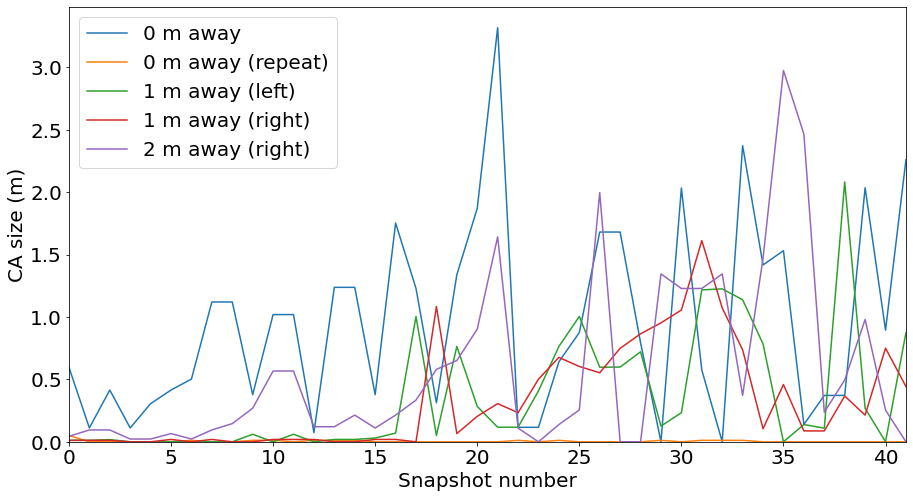

In [34]:
_, ax = plt.subplots()
for ca_size in ca_sizes:
    ax.plot(ca_size)
ax.set_xlabel("Snapshot number")
ax.set_ylabel("CA size (m)")
ax.set_xlim(0, len(snapshots) - 1)
ax.set_ylim(bottom=0)
ax.legend(descriptions);

In [35]:
%%HTML
<div align="middle">
<h2>Why is dataset2 crap?</h2>
<video width="80%" playback_rate="4" controls loop>
    <source src="dataset2.mp4">
</video></div>

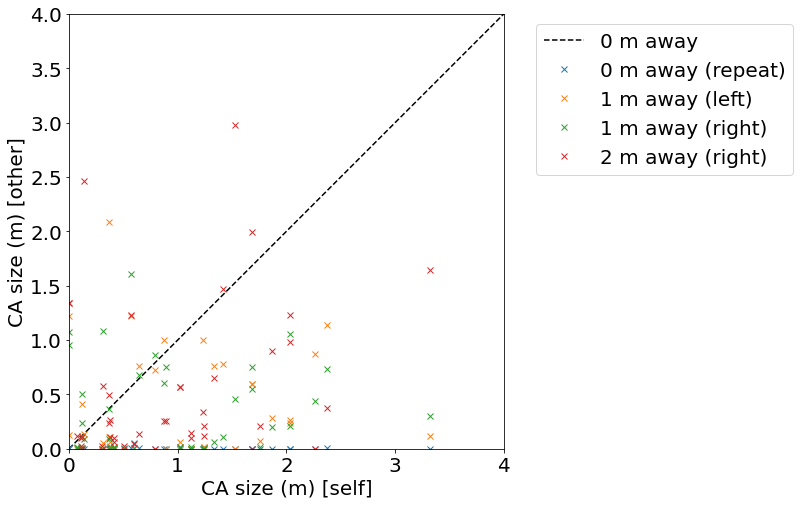

In [36]:
# SKIP THIS ONE FOR THE PRESENTATION
_, ax = plt.subplots()
ax.plot([0, 7], [0, 7], "k--")
for ca_size in ca_sizes[1:]:
    ax.plot(ca_sizes[0], ca_size, "x")
ax.axis("square")
ax.set_xlim(0, 4)
ax.set_ylim(0, 4)
ax.set_xlabel("CA size (m) [self]")
ax.set_ylabel("CA size (m) [other]")
ax.legend(descriptions, bbox_to_anchor=(1.05, 1), loc="upper left");

In [37]:
def get_best_ridf(diffs):
    best_over_rot = np.min(diffs, axis=1)
    best_row = np.argmin(best_over_rot)
    return diffs[best_row, :]


def ridf_to_radians(diffs):
    bestcols = np.argmin(diffs, axis=-1)
    ths = 2 * math.pi * bestcols / diffs.shape[-1]
    return ths


def plot_arrows(ax):
    test_dists = range(0, 55, 3)
    for db, ims, line in zip(dbs, images, lines):
        colour = line[0].get_color()
        head_offset = db.calculate_heading_offset(0.5)
        test_frames = [
            np.argmin(np.abs(db.distance - test_dist)) for test_dist in test_dists
        ]

        ims_sel = [ims[fr] for fr in test_frames]

        # Angle is negative because we want to rotate relative to image, not snapshot
        heads = [
            -ridf_to_radians(get_best_ridf(nb.ridf(snapshots, im, step=2)))
            for im in ims_sel
        ]
        heads = [head + head_offset for head in heads]
        x = [db.x[i] for i in test_frames]
        y = [db.y[i] for i in test_frames]
        u = [math.cos(head) for head in heads]
        v = [math.sin(head) for head in heads]

        ax.quiver(
            x,
            y,
            u,
            v,
            angles="xy",
            color=colour,
            zorder=10,
            scale_units="xy",
            scale=0.5,
        )

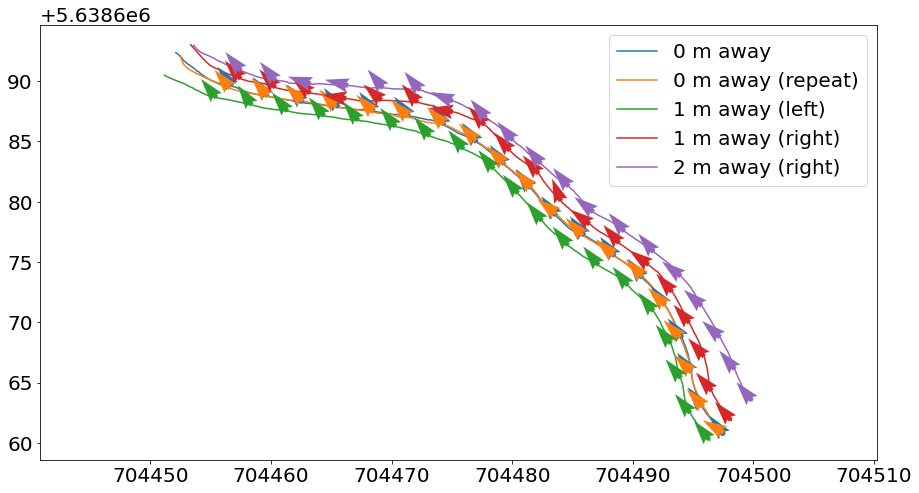

In [38]:
_, ax = plt.subplots()
ax.axis("equal")
lines = [plot_route(ax, db) for db in dbs]
plot_arrows(ax)
ax.legend(descriptions);